## Data Preprocessing

### Reading and Shuffling data

In [1]:
import pandas as pd

data = pd.read_csv('data/emails.csv', usecols=['text', 'spam'])

# shuffling the data and droping the index which will be created after shuffling
data = data.sample(frac=1).reset_index(drop=True)
data

,text,spam
0,Subject: invitation to cera multiclient study ...,0
1,Subject: chheep medz how to save o vacationis...,1
2,Subject: entouch newsletter business highligh...,0
3,Subject: re : f / u to dr . kaminski @ enron f...,0
4,"Subject: yyyy , do you know the hgh difference...",1
...,...,...
5726,Subject: re : var and credit meeting on wednes...,0
5727,Subject: your approval is overdue : access req...,0
5728,Subject: re : credit risk technical article b...,0
5729,Subject: failure notice hi . this is the qmai...,1


### Dropping null and duplicate values

In [2]:
print(data.isnull().sum())

data.dropna(inplace=True)

print('\nAfter dropping nulls:\ndata shape:', data.shape)

data.duplicated()

data.drop_duplicates(inplace=True)

print('\nAfter dropping duplicates:\ndata shape:', data.shape)

text    0
spam    2
dtype: int64

After dropping nulls:
data shape: (5729, 2)

After dropping duplicates:
data shape: (5696, 2)


### Data Cleansing 

In [3]:
# manipulating text
data['text'] = data['text'].str.replace('Subject: ', '')

# cleansing spam column values [0 means not spam, 1 means spam]
print(data['spam'].unique(),'\n')
data = data[data['spam'].isin(['0','1'])]
data['spam'] = data['spam'].apply(pd.to_numeric)

data = data.sample(frac=1).reset_index(drop=True)
data

['0' '1'
 ' its termination would not  have such a phenomenal impact on the power situation .  however '
 ' mr suresh prabhu '] 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,text,spam
0,weather derivatives : under cover - - - - - -...,0
1,re : mgmt 656 let me know if you need anythin...,0
2,"re : "" white paper "" vince & vasant , the en...",0
3,"re : visit to enron nick , the airport is ab...",0
4,make your dialup go faster how have you been ...,1
...,...,...
5689,"re : exotica . xla hi anjam , thanks for the...",0
5690,re : congratulations thanks vince and likewis...,0
5691,delivery status notification ( failure ) this...,1
5692,"re : eol clayton , great news . i would like...",0


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

# data['text'] = re.sub(^a-zA-Z)

nltk.download('stopwords')
stpwrds = stopwords.words('english')

stemmer = PorterStemmer()

stoplist = stpwrds + list(punctuation)

data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(lambda i: ' '.join([stemmer.stem(word) for word in i.split() if ((word not in stoplist) & (~word.isdigit()))]))
data = data[data['text'].apply(lambda i: len(i) >= 10)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Splitting Test and Training data

In [5]:
print('length of data:', len(data))
split_size = int(len(data) * .1)

print('split_size value:', split_size, '\n')
x_train = data['text'][split_size:]
y_train = data['spam'][split_size:]

x_test= data['text'][:split_size]
y_test = data['spam'][:split_size]

print('x_train:', x_train)
print('x_train shape:', x_train.shape, '\n')
print('y_train:', y_test)

length of data: 5692
split_size value: 569 

x_train: 569     storag model john want thank compliment work d...
570     banner life upgrad effect februari banner exte...
571     confirm need pleas repli email messag confirm ...
572     urgent deadlin rsvp jan nd invit energi financ...
573     ee risk manag present octob pleas present frid...
                              ...                        
5689    exotica xla hi anjam thank info afraid one thi...
5690    congratul thank vinc likewis congratul promot ...
5691    deliveri statu notif failur automat gener deli...
5692    eol clayton great news would like sit tom stin...
5693    latest draft comment vinc latest effort would ...
Name: text, Length: 5123, dtype: object
x_train shape: (5123,) 

y_train: 0      0
1      0
2      0
3      0
4      1
      ..
564    0
565    0
566    0
567    1
568    0
Name: spam, Length: 569, dtype: int64


### Generating Tokens, Sequencing and Padding

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
total_words = len(tokenizer.word_index)

print(total_words)

24406


In [7]:
import numpy as np

x_train_seq = tokenizer.texts_to_sequences(x_train)

max_len = max([len(i) for i in x_train_seq])
print('maximum length of x_train sequence:', max_len)
x_train = np.array(pad_sequences(x_train_seq, maxlen=max_len, padding='pre'))
print(x_train.shape)

x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test = np.array(pad_sequences(x_test_seq, maxlen=max_len, padding='pre'))


maximum length of x_train sequence: 2670
(5123, 2670)


## Creating Model and Training

In [8]:
from tensorflow.keras import Sequential, layers, optimizers, losses

model = Sequential([
                  layers.Embedding(input_dim=total_words+1, output_dim=16, input_length=max_len),

                  layers.Bidirectional(layers.LSTM(24, return_sequences=True)),
                  layers.Dropout(.25),
                  layers.LSTM(32),
                  layers.BatchNormalization(),

                  layers.Dense(40, activation='relu'),
                  layers.Dropout(.5),
                  layers.Dense(2, activation=tf.nn.softmax)
])

model.summary()
model.compile(optimizer=optimizers.Adam(lr=1e-3), loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(x_train, y_train, verbose=2, epochs=8, validation_split=0.1)

print('\nSaving model...')
model.save('model/model.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2670, 16)          390512    
_________________________________________________________________
bidirectional (Bidirectional (None, 2670, 48)          7872      
_________________________________________________________________
dropout (Dropout)            (None, 2670, 48)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10368     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 40)                1320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0

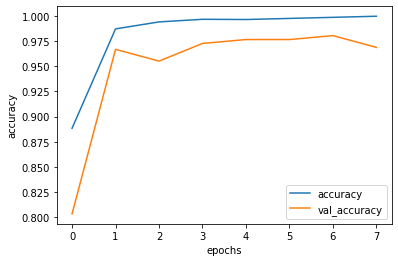

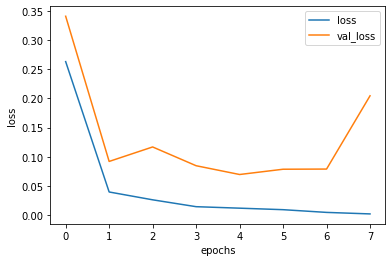

In [9]:
import matplotlib.pyplot as plt

def show_graph(h, s):
    plt.plot(h.history[s])
    plt.plot(h.history['val_' + s])
    plt.xlabel('epochs')
    plt.ylabel(s)
    plt.legend([s, 'val_' + s])
    plt.show()

show_graph(history, 'accuracy')
show_graph(history, 'loss')

## Testing 

In [10]:
model_1 = tf.keras.models.load_model('model/model.h5')

model_1.evaluate(x_test, y_test, verbose=2)

18/18 - 2s - loss: 0.1001 - accuracy: 0.7698


[0.10009822249412537, 0.7697715163230896]

In [17]:
emails = ["JobSearch information letter (ref. 3792idiot) - Avangar Technologies announces the beginning of a new unprecendented global employment campaign. reviser yeller winers butchery twenties Due to company's exploding growth Avangar is expanding business to the European region. During last employment campaign over 1500 people worldwide took part in Avangar's business and more than half of them are currently employed by the company."        , "AMATEUR TEEN WEBCAMS - FROM AROUND THE WORLD OR RIGHT NEXT DOOR - The people who solicit business from the clients of other sites know perfectly well that they have no pre-existing business relationship with the recipients. Some site-newbies send just one or two emails and are quoted on our 'named' page having been unable to read the clear terms of use of antespam protected email addresses"
        , "On Demand Webinar Access The London Resort will be a tier one theme park on the bank of the River Thames 17 minutes from Central London."
        , "Submit your travel related site! - If you own a travel related website, why not submit your site to our directory."
        , "Happening Now ** 70% OFF Membership ** Don't Miss This BLACK FRIDAY With Us! Offer Ends Today! Sale of 70% off PRO membership--Offered only once a year. Offer ends TODAY Friday 11/27/2020."
        , "Here comes another year of giving thanks for all the blessings we received. Happy Thanksgiving to everyone celebrating. I hope you have a great year ahead. Happy thanksgiving."
        , "Great news, we’re progressing your application through to phone interview! This will be a quick call to get to know more about your skills and experience in relation to the role. Please let me know all your available time slots by selecting them from the calendar linked below."
]

email_seq = tokenizer.texts_to_sequences(emails)
email_padd = pad_sequences(email_seq, maxlen=max_len, padding='pre')

prob = model_1.predict(email_padd)
pred = prob.argmax(axis=1)


classifier = {'No':0, 'Yes':1}
classifier_key = list(classifier.keys())
classifier_value = list(classifier.values())


for idx, i in enumerate(pred):

    print(f'Email: {emails[idx]} \nSpam: {classifier_key[classifier_value.index(i)]} {(prob[idx][i] * 100):.2f}%\n')


Email: JobSearch information letter (ref. 3792idiot) - Avangar Technologies announces the beginning of a new unprecendented global employment campaign. reviser yeller winers butchery twenties Due to company's exploding growth Avangar is expanding business to the European region. During last employment campaign over 1500 people worldwide took part in Avangar's business and more than half of them are currently employed by the company. 
Spam: Yes 100.00%

Email: AMATEUR TEEN WEBCAMS - FROM AROUND THE WORLD OR RIGHT NEXT DOOR - The people who solicit business from the clients of other sites know perfectly well that they have no pre-existing business relationship with the recipients. Some site-newbies send just one or two emails and are quoted on our 'named' page having been unable to read the clear terms of use of antespam protected email addresses 
Spam: Yes 100.00%

Email: On Demand Webinar Access The London Resort will be a tier one theme park on the bank of the River Thames 17 minutes 